# Exercise 11: Mixture Models and Density Estimation

### Objective:
This exercise focuses on understanding the Gaussian Mixture Model (GMM), how the Expectation-Maximization (EM) algorithm is used to estimate parameters, and the evaluation of clustering performance using information criteria like BIC and AIC. Additionally, the exercise explores density estimation methods (KDE, KNN) and their use in outlier detection.

### Key Topics:
- Gaussian Mixture Model (GMM)
- EM algorithm for clustering
- Cross-validation, AIC, and BIC for model selection
- Density estimation with histograms, KDE, and KNN
- Outlier and anomaly detection

### Structure:
1. **Gaussian Mixture Model and EM Algorithm (11.1):**
   - Learn about GMM clustering and evaluate the performance with AIC, BIC, and cross-validation.

2. **Density Estimation (11.2):**
   - Estimate data density using KDE and KNN density estimators.

3. **Outlier Detection (11.3):**
   - Identify outliers based on low-density estimates using KDE and KNN.

4. **Handwritten Digits Analysis (11.4):**
   - Analyze digit data to identify outliers using various density estimation methods.

### Goals:
By completing this exercise, you'll be able to:
- Use GMM for clustering and parameter estimation.
- Choose the optimal number of clusters using AIC, BIC, and cross-validation.
- Apply density estimation techniques to identify patterns in data.
- Detect anomalies and outliers effectively.

### Section 11.1: Gaussian Mixture Models and EM Algorithm

**Objective**:  
In this section, we explore **Gaussian Mixture Models (GMM)**, a probabilistic clustering method that assumes data is generated from a mixture of Gaussian distributions. Using the **Expectation-Maximization (EM)** algorithm, we iteratively refine the parameters of the Gaussian components to maximize the likelihood of the observed data.

Multivariate Gaussian distribution: 
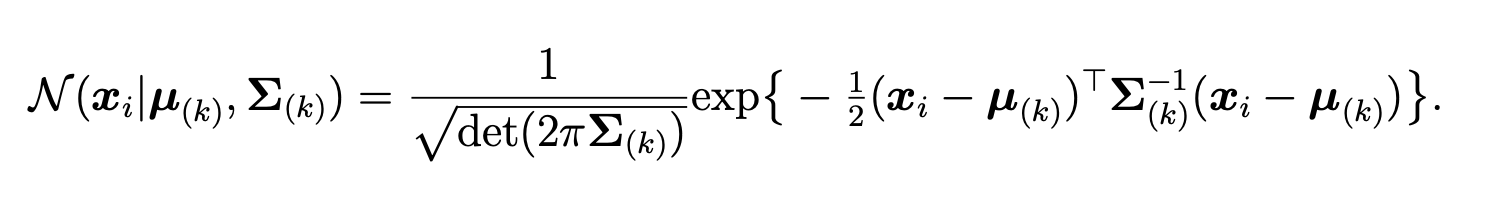

Probability in GMM: 
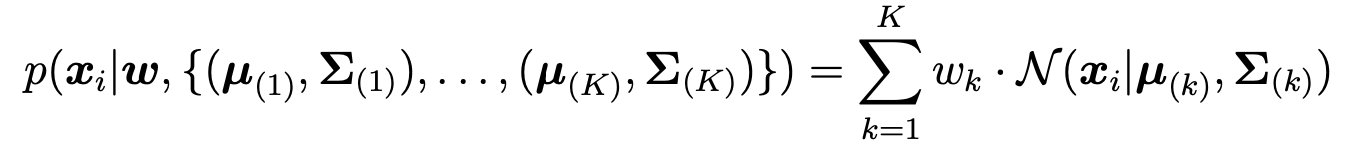

EM algorithm: 
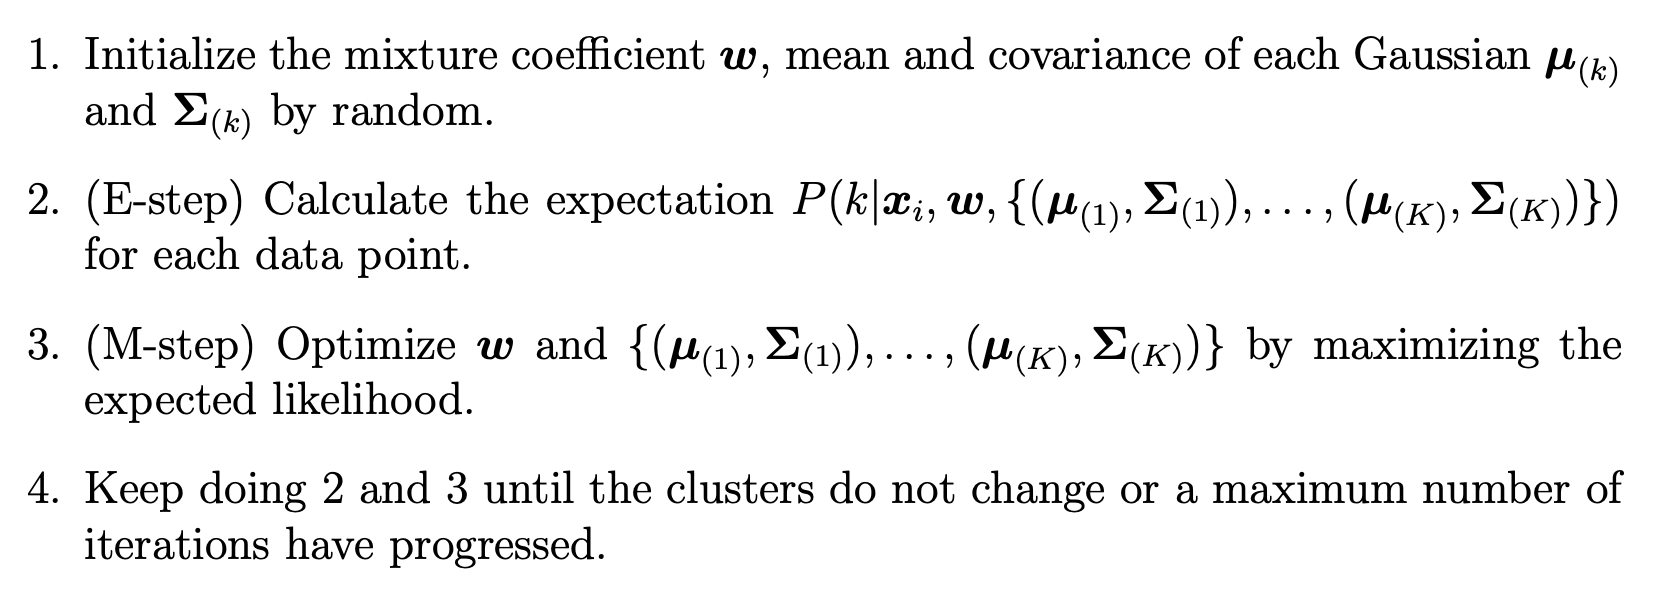

**Key Points**:
- GMM can handle clusters of varying sizes and elliptical shapes.
- EM algorithm alternates between assigning points to clusters (E-step) and updating Gaussian parameters (M-step).
- Model selection is performed using **Akaike Information Criterion (AIC)**, **Bayesian Information Criterion (BIC)**, and cross-validation.

### Exercise 11.1.1: Gaussian Mixture Model Initialization

**Objective**:  
The task involves initializing and fitting a Gaussian Mixture Model (GMM) to a dataset. The focus is on:
1. Loading the dataset.
2. Initializing the GMM with a specific number of components.
3. Performing clustering using the EM algorithm.

This task provides a basic understanding of GMM and how initialization affects the results.

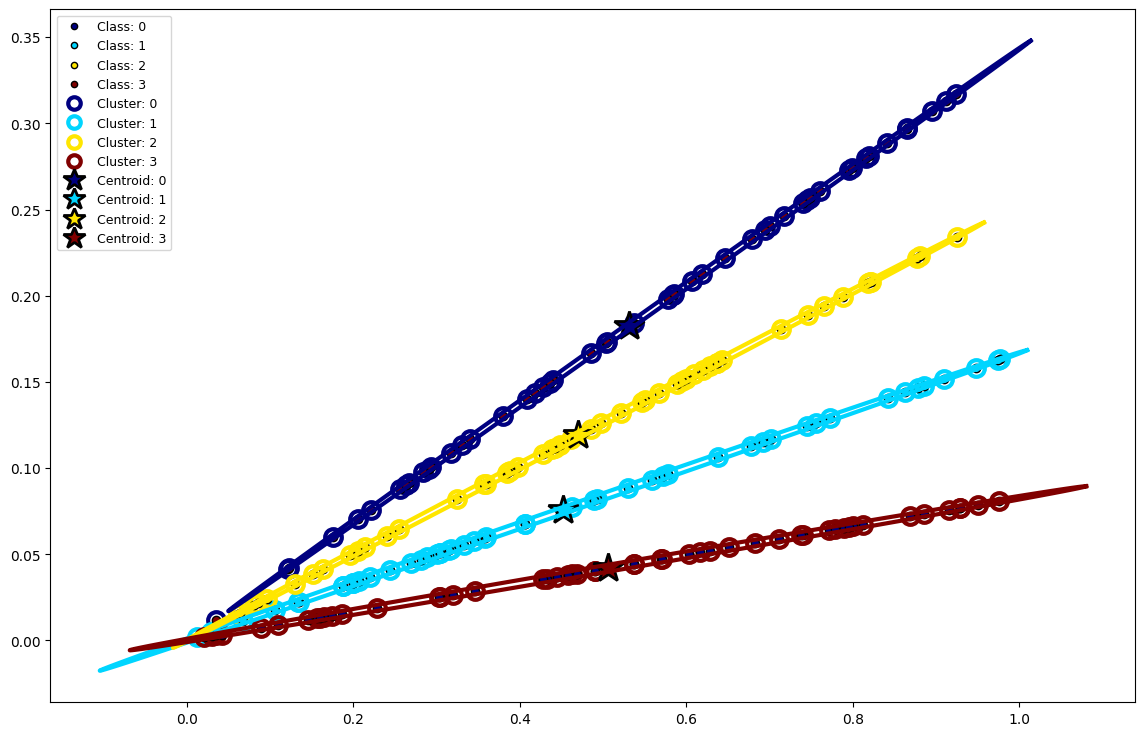

Ran Exercise 11.1.1


In [6]:
# exercise 11.1.1
import importlib_resources
import numpy as np
from matplotlib.pyplot import figure, show
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture

from dtuimldmtools import clusterplot

filename = importlib_resources.files("dtuimldmtools").joinpath("data/synth2.mat")

# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"].squeeze()]
classNames = [name[0][0] for name in mat_data["classNames"]]
# X_old = X
# X = np.hstack([X,X])
N, M = X.shape
C = len(classNames)
# Number of clusters
K = 4
cov_type = "full"  # e.g. 'full' or 'diag'

# define the initialization procedure (initial value of means)
initialization_method = "random"  #  'random' or 'kmeans'
# random signifies random initiation, kmeans means we run a K-means and use the
# result as the starting point. K-means might converge faster/better than
# random, but might also cause the algorithm to be stuck in a poor local minimum

# type of covariance, you can try out 'diag' as well
reps = 10
# number of fits with different initalizations, best result will be kept
# Fit Gaussian mixture model
gmm = GaussianMixture(
    n_components=K,
    covariance_type=cov_type,
    n_init=reps,
    tol=1e-6,
    reg_covar=1e-6,
    init_params=initialization_method,
).fit(X)
cls = gmm.predict(X)
# extract cluster labels
cds = gmm.means_
# extract cluster centroids (means of gaussians)
covs = gmm.covariances_
# extract cluster shapes (covariances of gaussians)
if cov_type.lower() == "diag":
    new_covs = np.zeros([K, M, M])

    count = 0
    for elem in covs:
        temp_m = np.zeros([M, M])
        new_covs[count] = np.diag(elem)
        count += 1

    covs = new_covs

# Plot results:
figure(figsize=(14, 9))
clusterplot(X, clusterid=cls, centroids=cds, y=y, covars=covs)
show()

## In case the number of features != 2, then a subset of features most be plotted instead.
# figure(figsize=(14,9))
# idx = [0,1] # feature index, choose two features to use as x and y axis in the plot
# clusterplot(X[:,idx], clusterid=cls, centroids=cds[:,idx], y=y, covars=covs[:,idx,:][:,:,idx])
# show()

print("Ran Exercise 11.1.1")

### 11.1.2 Observation Assignment and Effect of Scaling
#### 1. Observation Assignment in GMM vs. k-Means
- **k-Means Clustering**:
  - Points are assigned to the cluster with the **nearest centroid** based on **Euclidean distance**.
  - This assignment is deterministic and solely depends on proximity to the centroid.

- **Gaussian Mixture Model (GMM)**:
  - Observations are assigned to clusters probabilistically, based on the likelihood of the point under the Gaussian distribution of each cluster.
  - It is possible for a point to belong to a cluster farther away in Euclidean distance if the likelihood of the point under the Gaussian is higher than for closer clusters.

**Conclusion**: Unlike k-means, GMM does not always assign points to the closest cluster in terms of Euclidean distance, as it considers the Gaussian distribution parameters (mean and covariance).

---

#### 2. Effect of Scaling on Clustering
- **k-Means Clustering**:
  - Sensitive to the scaling of variables since it directly uses Euclidean distance for assignment.
  - Variables with larger scales dominate the clustering results unless standardized.

- **Gaussian Mixture Model (GMM)**:
  - GMM is also **affected by scaling**, as the covariance matrix reflects the variance of the variables.
  - A variable with a larger scale can disproportionately influence the clustering outcome by dominating the covariance matrix.

**Conclusion**: GMM, like k-means, is not robust to variable scaling. Normalization or standardization is necessary to ensure all variables contribute equally to the clustering process.

### Exercise 11.1.3: Discussion on GMM Cross-Validation and Clustering

In this task, we analyze the validation of the number of clusters for a Gaussian Mixture Model (GMM) using cross-validation. Specifically, the goal is to:
- Train the model on training data using the Expectation-Maximization (EM) algorithm.
- Evaluate how likely the test data points are under the learned GMM parameters using the logarithm of the likelihood of the test data.
- Discuss the implications of using varying numbers of clusters for GMM.

#### Key Questions:
1. If 100 data points and one cluster are used, what would the optimal solution be under the GMM using the EM algorithm, and how well would this generalize to test data?
2. If 100 data points and 100 clusters are used, what would the solution be, and how well would it generalize?
3. What happens if an intermediate number of clusters is used?
4. How does the Bayesian Information Criteria (BIC) and Akaike’s Information Criteria (AIC) penalize model complexity compared to cross-validation?

This exercise highlights the balance between model complexity and data fitting when choosing the optimal number of clusters.

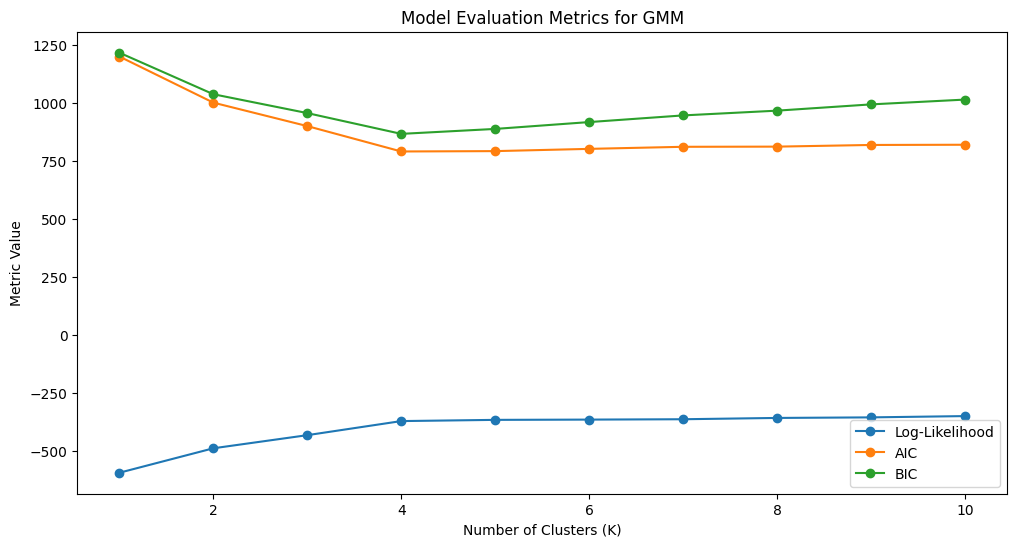

Completed Exercise 11.1.3


In [9]:
# exercise 11.1.3
import importlib_resources
import numpy as np
from matplotlib.pyplot import figure, plot, show, title, legend, xlabel, ylabel
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture

# Load data
filename = importlib_resources.files("dtuimldmtools").joinpath("data/synth1.mat")
mat_data = loadmat(filename)
X = mat_data["X"]

# Number of clusters to evaluate
cluster_range = range(1, 11)  # Evaluating from 1 to 10 clusters

# Store log-likelihood, AIC, and BIC for each number of clusters
log_likelihood = []
aic_values = []
bic_values = []

for k in cluster_range:
    # Fit GMM with k components
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(X)
    
    # Compute log-likelihood, AIC, and BIC
    log_likelihood.append(gmm.score(X) * len(X))  # Total log-likelihood
    aic_values.append(gmm.aic(X))
    bic_values.append(gmm.bic(X))

# Plot results
figure(figsize=(12, 6))
plot(cluster_range, log_likelihood, label="Log-Likelihood", marker="o")
plot(cluster_range, aic_values, label="AIC", marker="o")
plot(cluster_range, bic_values, label="BIC", marker="o")
title("Model Evaluation Metrics for GMM")
legend()
xlabel("Number of Clusters (K)")
ylabel("Metric Value")
show()

# Interpretation
print("Completed Exercise 11.1.3")

### AIC and BIC: Model Selection Criteria

#### **Akaike Information Criterion (AIC)**
- **Purpose**: AIC measures the trade-off between model complexity and goodness of fit.
- **Formula**:  
 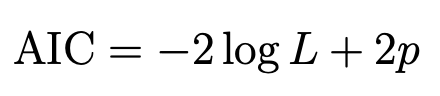
  - \(p\): Number of model parameters.
  - \(L\): Maximum likelihood of the model.
- **Interpretation**: Lower AIC values indicate a better balance between model complexity and fit. AIC penalizes complexity less than BIC.

#### **Bayesian Information Criterion (BIC)**
- **Purpose**: BIC is similar to AIC but imposes a stricter penalty for model complexity, favoring simpler models.
- **Formula**:  
 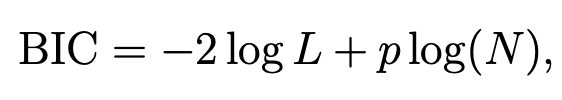
  - \(n\): Number of data points.
  - \(p\): Number of model parameters.
  - \(L\): Maximum likelihood of the model.
- **Interpretation**: Lower BIC values indicate a better model. BIC tends to select simpler models compared to AIC, as it penalizes complexity more heavily.

#### **Comparison**:
- **AIC**: More lenient and suitable when prediction accuracy is prioritized.
- **BIC**: Stricter and suitable when simpler models or smaller datasets are preferred.

Both are widely used to evaluate and select the optimal number of clusters in Gaussian Mixture Models (GMMs).

## Exercise 11.1.4: Discussion on AIC and BIC
- **BIC (Bayesian Information Criterion)** penalizes model complexity more than **AIC (Akaike Information Criterion)**.
- The penalty term in BIC grows with the logarithm of the number of observations (\(p \cdot \ln(n)\)), whereas AIC has a constant penalty proportional to the number of parameters (\(2p\)).
- For larger datasets (\(n\)), the logarithmic term in BIC becomes significantly larger than AIC's penalty, making BIC stricter in discouraging additional model complexity.

**Implication**:
- BIC tends to favor simpler models, especially as dataset size increases.
- AIC is more lenient and allows for more complex models, which might be preferable for predictive tasks on smaller datasets.

## Exercise 11.1.5: Evaluating Clustering Metrics

### Objective
In this task, we will compute and compare the following metrics for determining the optimal number of clusters:
- **Bayesian Information Criterion (BIC)**
- **Akaike Information Criterion (AIC)**
- **10-fold Cross-Validation Log Likelihood**.

We will:
1. Use the `synth1` dataset.
2. Evaluate the number of clusters \( K \) from 1 to 10.
3. Use 10 replicates to mitigate poor initialization.

### Questions to Consider
- How do the metrics behave as \( K \) increases?
- Which metric provides the clearest trade-off between model complexity and fit?
- Is the optimal \( K \) consistent across the three metrics?

### Expected Outcome
By analyzing the results, we will identify the optimal number of clusters and understand the trade-offs between these evaluation methods.

Fitting model for K=1
Fitting model for K=2
Fitting model for K=3
Fitting model for K=4


/Users/jonaswiendl/anaconda3/envs/introML/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fitting model for K=5
Fitting model for K=6


/Users/jonaswiendl/anaconda3/envs/introML/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Users/jonaswiendl/anaconda3/envs/introML/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fitting model for K=7


/Users/jonaswiendl/anaconda3/envs/introML/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fitting model for K=8


/Users/jonaswiendl/anaconda3/envs/introML/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fitting model for K=9
Fitting model for K=10


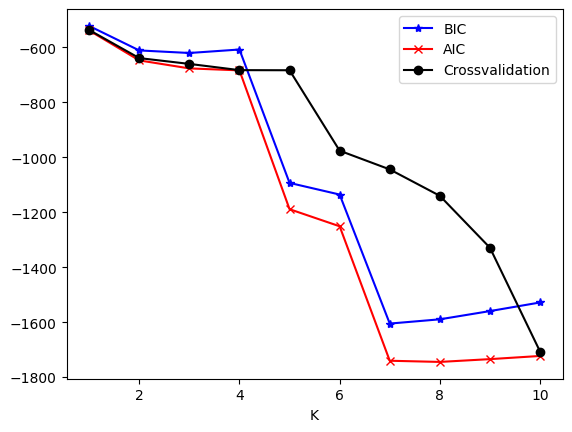

Ran Exercise 11.1.5


In [10]:
# exercise 11.1.5
import importlib_resources
import numpy as np
from matplotlib.pyplot import figure, legend, plot, show, xlabel
from scipy.io import loadmat
from sklearn import model_selection
from sklearn.mixture import GaussianMixture

filename = importlib_resources.files("dtuimldmtools").joinpath("data/synth2.mat")

# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"].squeeze()]
classNames = [name[0][0] for name in mat_data["classNames"]]
N, M = X.shape
C = len(classNames)


# Range of K's to try
KRange = range(1, 11)
T = len(KRange)

covar_type = "full"  # you can try out 'diag' as well
reps = 3  # number of fits with different initalizations, best result will be kept
init_procedure = "kmeans"  # 'kmeans' or 'random'

# Allocate variables
BIC = np.zeros((T,))
AIC = np.zeros((T,))
CVE = np.zeros((T,))

# K-fold crossvalidation
CV = model_selection.KFold(n_splits=10, shuffle=True)

for t, K in enumerate(KRange):
    print("Fitting model for K={0}".format(K))

    # Fit Gaussian mixture model
    gmm = GaussianMixture(
        n_components=K,
        covariance_type=covar_type,
        n_init=reps,
        init_params=init_procedure,
        tol=1e-6,
        reg_covar=1e-6,
    ).fit(X)

    # Get BIC and AIC
    BIC[t,] = gmm.bic(X)
    AIC[t,] = gmm.aic(X)

    # For each crossvalidation fold
    for train_index, test_index in CV.split(X):
        # extract training and test set for current CV fold
        X_train = X[train_index]
        X_test = X[test_index]

        # Fit Gaussian mixture model to X_train
        gmm = GaussianMixture(
            n_components=K, covariance_type=covar_type, n_init=reps
        ).fit(X_train)

        # compute negative log likelihood of X_test
        CVE[t] += -gmm.score_samples(X_test).sum()


# Plot results

figure(1)
plot(KRange, BIC, "-*b")
plot(KRange, AIC, "-xr")
plot(KRange, 2 * CVE, "-ok")
legend(["BIC", "AIC", "Crossvalidation"])
xlabel("K")
show()

print("Ran Exercise 11.1.5")


### Table: Comparison of AIC, BIC, and Cross-Validation

| **Criterion**        | **Complexity Penalty** | **Assumption Dependent** | **Computational Cost** | **Suitable Use Cases**                                    |
|-----------------------|------------------------|---------------------------|-------------------------|----------------------------------------------------------|
| **AIC**              | Moderate              | Yes                       | Low                     | Predictive modeling with smaller datasets.               |
| **BIC**              | High                  | Yes                       | Low                     | Model selection for interpretability and large datasets. |
| **Cross-Validation** | Implicit              | No                        | High                    | General-purpose model evaluation and comparison.         |

# 11.2: Density Estimation

## Introduction
Density estimation is a technique to estimate the underlying data distribution. It helps us infer properties about a population using a finite data sample. 

In this section, we explore three methods of density estimation:
1. **Histogram-Based Density Estimation:** A simple approach dividing the data range into bins and counting the number of points in each bin.
2. **Kernel Density Estimation (KDE):** A non-parametric method where a kernel function (e.g., Gaussian) is placed around each data point to estimate density.
3. **k-Nearest Neighbor (KNN) Density Estimation:** Estimates density based on the distances to the k-nearest neighbors, often useful in regions with varying densities.

These methods are applied to an artificially generated one-dimensional dataset formed by a mixture of three Gaussian distributions:
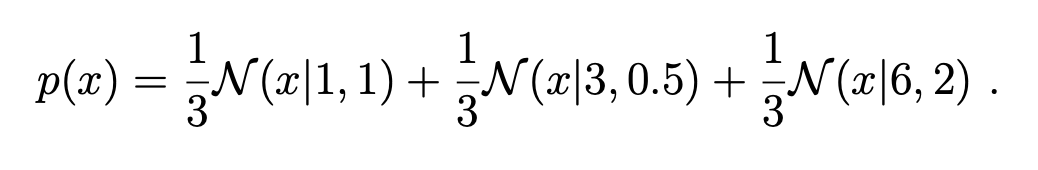

By analyzing these techniques, we aim to understand how they model the data density and compare their strengths and weaknesses.

## 11.2.1: Histogram-Based Density Estimation
- This task involves generating data from a mixture of three Gaussian distributions.
- A histogram with 50 bins is used to visualize the density.
- Experiment with different parameters of the mixture and vary the number of bins to see their impact on the histogram.

### Key Questions:
1. Can you identify the Gaussian components in the histogram?
2. What happens when the parameters or the number of bins change?

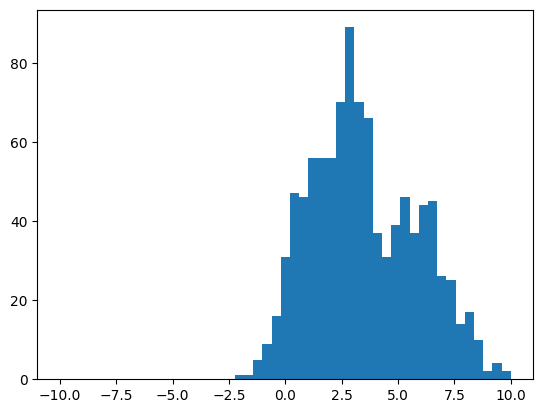

Ran Exercise 11.2.1


In [13]:
# exercise 11_2_1
import numpy as np
from matplotlib.pyplot import figure, hist, show

# Number of data objects
N = 1000

# Number of attributes
M = 1

# x-values to evaluate the histogram
x = np.linspace(-10, 10, 50)

# Allocate variable for data
X = np.empty((N, M))

# Mean and covariances
m = np.array([1, 3, 6])
s = np.array([1, 0.5, 2])

# Draw samples from mixture of gaussians
c_sizes = np.random.multinomial(N, [1.0 / 3, 1.0 / 3, 1.0 / 3])
for c_id, c_size in enumerate(c_sizes):
    X[
        c_sizes.cumsum()[c_id] - c_sizes[c_id] : c_sizes.cumsum()[c_id], :
    ] = np.random.normal(m[c_id], np.sqrt(s[c_id]), (c_size, M))


# Plot histogram of sampled data
figure()
hist(X, x)
show()

print("Ran Exercise 11.2.1")


## 11.2.2: Kernel Density Estimation

- **Objective:** Estimate the density of data using a kernel density estimator (KDE) with a Gaussian kernel.
- **Key Details:**
  - The KDE smoothens the density by placing a Gaussian kernel at each data point.
  - Kernel width (or bandwidth) determines the smoothness of the density:
    - Smaller widths result in more detailed density, which may overfit noise.
    - Larger widths produce smoother densities, potentially missing finer details.
  - The density is computed over the range \([-10, 10]\) for visualization.

### Discussion Points:
1. How does the KDE compare to the histogram from **11.2.1**?
2. What is the effect of varying the kernel width on the density estimation?
3. How might you determine an optimal kernel width?

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_62378/2100445460.py:4: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.kde import gaussian_kde


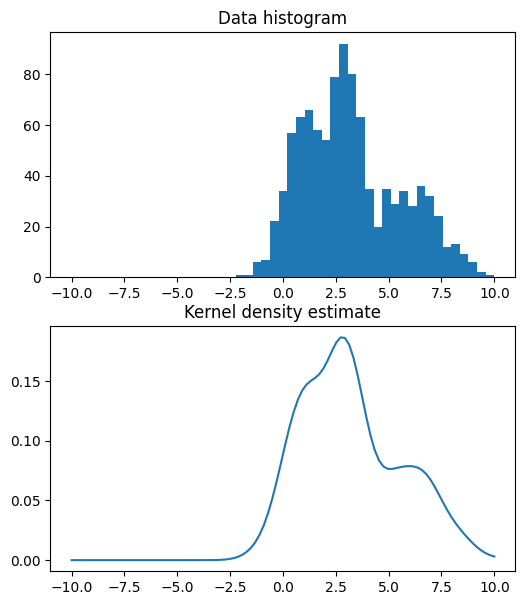

Ran Exercise 11.2.2


In [15]:
# exercise 11.2.2
import numpy as np
from matplotlib.pyplot import figure, hist, plot, show, subplot, title
from scipy.stats.kde import gaussian_kde

# Draw samples from mixture of gaussians (as in exercise 11.1.1)
N = 1000
M = 1
x = np.linspace(-10, 10, 50)
X = np.empty((N, M))
m = np.array([1, 3, 6])
s = np.array([1, 0.5, 2])
c_sizes = np.random.multinomial(N, [1.0 / 3, 1.0 / 3, 1.0 / 3])
for c_id, c_size in enumerate(c_sizes):
    X[
        c_sizes.cumsum()[c_id] - c_sizes[c_id] : c_sizes.cumsum()[c_id], :
    ] = np.random.normal(m[c_id], np.sqrt(s[c_id]), (c_size, M))


# x-values to evaluate the KDE
xe = np.linspace(-10, 10, 100)

# Compute kernel density estimate
kde = gaussian_kde(X.ravel())

# Plot kernel density estimate
figure(figsize=(6, 7))
subplot(2, 1, 1)
hist(X, x)
title("Data histogram")
subplot(2, 1, 2)
plot(xe, kde.evaluate(xe))
title("Kernel density estimate")
show()

print("Ran Exercise 11.2.2")


## 11.2.3: k-Nearest Neighbor (KNN) Density Estimation

- **Objective:** Estimate data density using the k-nearest neighbors method.
- **Key Details:**
  - Density is inversely proportional to the average distance to the \( K \)-nearest neighbors.
  - This method is sensitive to \( K \), which controls the local neighborhood size:
    - Smaller \( K \) focuses on fine-grained local density.
    - Larger \( K \) provides a smoother global estimate.
  - The density is computed over the range \([-10, 10]\) for visualization.

### Discussion Points:
1. How does the KNN density estimation compare to the histogram and KDE methods?
2. What is the impact of varying \( K \) on the density estimates?
3. How well does this method perform in regions with varying densities?

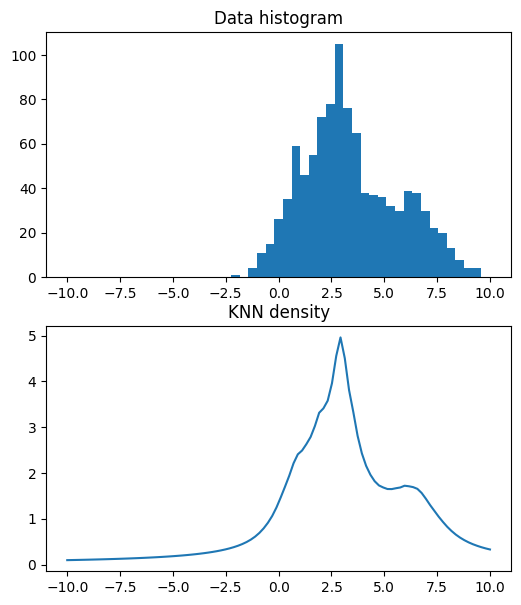

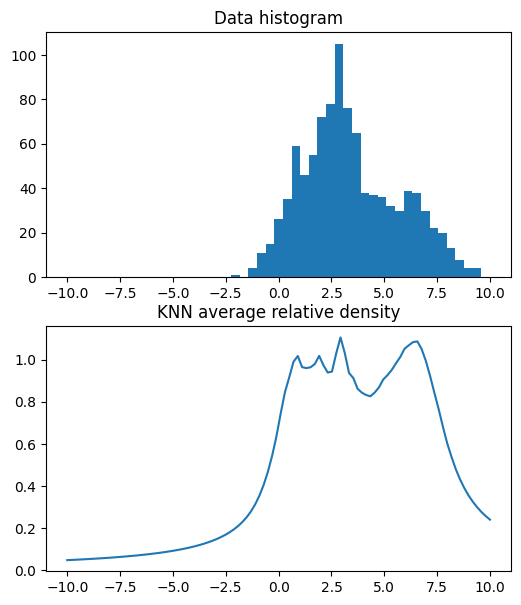

Ran Exercise 11.2.3


In [16]:
# exercise 11.2.3
import numpy as np
from matplotlib.pyplot import figure, hist, plot, show, subplot, title
from sklearn.neighbors import NearestNeighbors

# Draw samples from mixture of gaussians (as in exercise 11.1.1)
N = 1000
M = 1
x = np.linspace(-10, 10, 50)
X = np.empty((N, M))
m = np.array([1, 3, 6])
s = np.array([1, 0.5, 2])
c_sizes = np.random.multinomial(N, [1.0 / 3, 1.0 / 3, 1.0 / 3])
for c_id, c_size in enumerate(c_sizes):
    X[
        c_sizes.cumsum()[c_id] - c_sizes[c_id] : c_sizes.cumsum()[c_id], :
    ] = np.random.normal(m[c_id], np.sqrt(s[c_id]), (c_size, M))


# Number of neighbors
K = 200

# x-values to evaluate the KNN
xe = np.linspace(-10, 10, 100)

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K).fit(X)
D, i = knn.kneighbors(
    np.expand_dims(xe, axis=-1)
)  # note expand_dims is simple to make it (100,1) and not (100,) array

# Compute the density
knn_density = 1.0 / (D[:, 1:].sum(axis=1) / K)

# Compute the average relative density
DX, iX = knn.kneighbors(X)
knn_densityX = 1.0 / (DX[:, 1:].sum(axis=1) / K)
knn_avg_rel_density = knn_density / (knn_densityX[i[:, 1:]].sum(axis=1) / K)


# Plot KNN density
figure(figsize=(6, 7))
subplot(2, 1, 1)
hist(X, x)
title("Data histogram")
subplot(2, 1, 2)
plot(xe, knn_density)
title("KNN density")
# Plot KNN average relative density
figure(figsize=(6, 7))
subplot(2, 1, 1)
hist(X, x)
title("Data histogram")
subplot(2, 1, 2)
plot(xe, knn_avg_rel_density)
title("KNN average relative density")

show()

print("Ran Exercise 11.2.3")


# 11.3: Outlier Detection

## Introduction
Outliers are observations that differ significantly from other data points. They can arise due to errors, noise, or rare events. Two common definitions of outliers are:
1. **Hawkin's Definition:** An outlier is an observation that deviates so much from other observations that it raises suspicion of being generated by a different mechanism.
2. **Probabilistic Definition:** An outlier is an object with a low probability density under the data's distribution.

### Key Idea:
To detect outliers, we estimate the density of the data. Observations with significantly low density are potential outliers. This approach requires a reliable model of the data density, which can be achieved using methods such as:
- Kernel Density Estimation (KDE)
- k-Nearest Neighbor (KNN) Density Estimation

By analyzing the density at each data point, we can identify those that are far from the majority of the data and consider them outliers.

## 11.3.1: Outlier Detection Using KDE

- **Objective:** Use a kernel density estimator (KDE) to detect outliers in a dataset.
- **Task Details:**
  1. Add an outlier at \( X[-1,0] = -10 \) to the dataset.
  2. Fit a KDE model (using a Gaussian kernel) to estimate the density at each data point.
  3. Identify the 20 points with the lowest density and visualize their density values in a bar plot.

- **Script Details:**
  - To fit the KDE model, use the `gaussian_kde` class from `scipy.stats.kde`.
  - Evaluate the density for each data point using the `evaluate()` method.
  - Identify the indices of the 20 lowest-density points using the `argsort()` method.
  - Create a bar plot of the densities for the 20 points.

### Key Discussion Points:
1. Can the introduced outlier at \(-10\) be detected as one of the lowest-density points?
2. How does varying the kernel width affect the detection of outliers?
3. What happens when the kernel width is too small or too large?

The index of the lowest density object: 999


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_62378/3488516676.py:4: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.kde import gaussian_kde


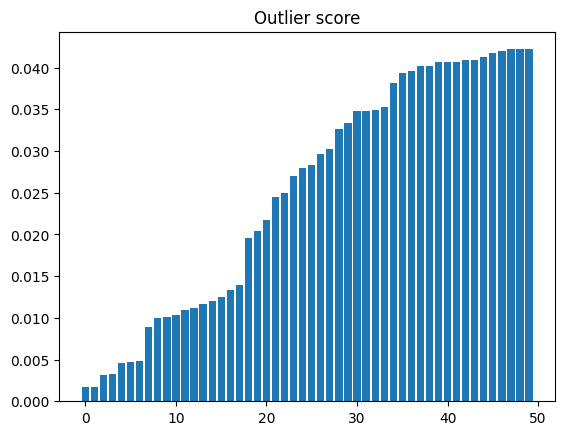

Ran Exercise 11.3.1


In [37]:
# exercise 11.3.1
import numpy as np
from matplotlib.pyplot import bar, figure, show, title
from scipy.stats.kde import gaussian_kde

# Draw samples from mixture of gaussians (as in exercise 11.1.1), add outlier
N = 1000
M = 1
x = np.linspace(-10, 10, 50)
X = np.empty((N, M))
m = np.array([1, 3, 6])
s = np.array([1, 0.5, 2])
c_sizes = np.random.multinomial(N, [1.0 / 3, 1.0 / 3, 1.0 / 3])
for c_id, c_size in enumerate(c_sizes):
    X[
        c_sizes.cumsum()[c_id] - c_sizes[c_id] : c_sizes.cumsum()[c_id], :
    ] = np.random.normal(m[c_id], np.sqrt(s[c_id]), (c_size, M))
X[-1, 0] = -10  # added outlier


# Compute kernel density estimate
kde = gaussian_kde(X.ravel(), bw_method=0.1)

scores = kde.evaluate(X.ravel())
idx = scores.argsort()
scores.sort()

print("The index of the lowest density object: {0}".format(idx[0]))

# Plot kernel density estimate
figure()
bar(range(50), scores[:50])
title("Outlier score")
show()

print("Ran Exercise 11.3.1")


	•	0.1: Narrower kernels, more detail but potentially overfitting.
	•	0.5: Balanced smoothing (default behavior).
	•	2.0: Broader kernels, less detail but smoother density.

## 11.3.2: Outlier Detection Using Leave-One-Out KDE and Optimal Kernel Width

- **Objective:** Use a leave-one-out kernel density estimator to detect outliers and find the optimal kernel width by evaluating the log-density across different widths.

### Task Details:
1. The leave-one-out KDE computes the density of each observation without including the observation itself in the density estimate.
2. Evaluate the log-density for a range of kernel widths and identify the width with the highest log-density.
3. Create a bar plot of the 20 lowest-density points using the optimal kernel width.

### Script Details:
- Use the function `gausKernelDensity()` from the toolbox for efficient leave-one-out KDE.
- The log-density for all observations is calculated as the sum of the log-densities for individual points.
- The optimal kernel width maximizes the total log-density.

### Steps:
1. Estimate the leave-one-out density for the dataset using `gausKernelDensity()` with different kernel widths.
2. Identify the kernel width with the highest log-density.
3. Plot the densities of the 20 lowest-density points as a bar chart.

### Key Discussion Points:
1. How does the leave-one-out density estimation compare to standard KDE?
2. What happens when the kernel width is too small or too large?
3. How does the choice of kernel width affect outlier detection?

Optimal estimated width is: 0.125
Lowest density: [0.00117359] for data object: 783


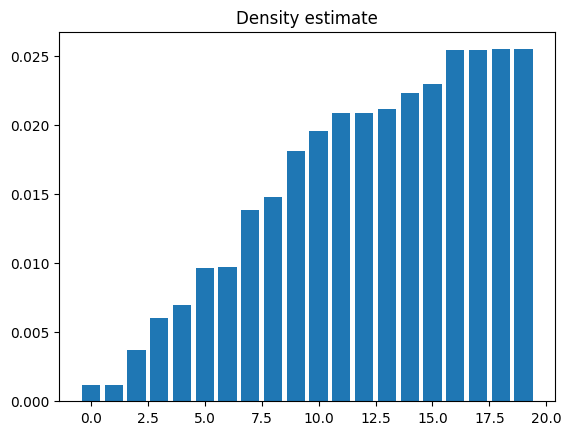

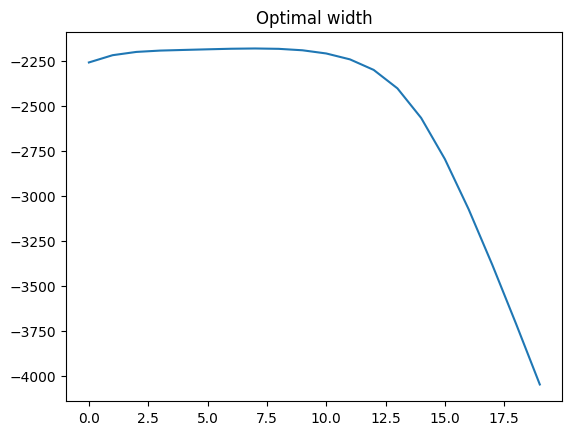

Ran Exercise 11.3.2


In [38]:
# exercise 11.3.2

import numpy as np
from matplotlib.pyplot import bar, figure, plot, show, title

from dtuimldmtools import gausKernelDensity

# Draw samples from mixture of gaussians (as in exercise 11.1.1)
N = 1000
M = 1
x = np.linspace(-10, 10, 50)
X = np.empty((N, M))
m = np.array([1, 3, 6])
s = np.array([1, 0.5, 2])
c_sizes = np.random.multinomial(N, [1.0 / 3, 1.0 / 3, 1.0 / 3])
for c_id, c_size in enumerate(c_sizes):
    X[
        c_sizes.cumsum()[c_id] - c_sizes[c_id] : c_sizes.cumsum()[c_id], :
    ] = np.random.normal(m[c_id], np.sqrt(s[c_id]), (c_size, M))


# Estimate the optimal kernel density width, by leave-one-out cross-validation
widths = 2.0 ** np.arange(-10, 10)
logP = np.zeros(np.size(widths))
for i, w in enumerate(widths):
    f, log_f = gausKernelDensity(X, w)
    logP[i] = log_f.sum()
val = logP.max()
ind = logP.argmax()

width = widths[ind]
print("Optimal estimated width is: {0}".format(width))

# Estimate density for each observation not including the observation
# itself in the density estimate
density, log_density = gausKernelDensity(X, width)

# Sort the densities
i = (density.argsort(axis=0)).ravel()
density = density[i]

# Display the index of the lowest density data object
print("Lowest density: {0} for data object: {1}".format(density[0], i[0]))

# Plot density estimate of outlier score
figure(1)
bar(
    range(20),
    density[:20].reshape(
        -1,
    ),
)
title("Density estimate")
figure(2)
plot(logP)
title("Optimal width")
show()

print("Ran Exercise 11.3.2")


# 11.4: Outlier Detection in Handwritten Digits

## Introduction
This task involves applying outlier detection techniques to a dataset of handwritten digits. The goal is to identify digit images that deviate significantly from others within the same class.

### Objectives:
1. Use kernel density estimation (KDE) with leave-one-out cross-validation to estimate the density of each data point and find the optimal kernel width.
2. Apply k-Nearest Neighbor (KNN) methods to detect outliers.
3. Compare outlier detection results using different methods.

### Dataset:
- The dataset contains images of handwritten digits.
- Each image is represented as a 256-dimensional vector (16x16 grayscale pixel grid).

### Steps:
1. Restrict the analysis to images of the digit "2" for computational efficiency.
2. Estimate densities and identify outliers using three methods:
   - Leave-one-out KDE.
   - KNN density estimation.
   - KNN average relative density estimation.
3. Plot the 20 images with the lowest density for each method and compare them to randomly selected images of "2".

## 11.4.1: Outlier Detection Using Leave-One-Out KDE

- **Objective:** Detect outliers in the handwritten digits dataset using leave-one-out KDE and find the optimal kernel width for density estimation.

### Task Details:
1. **Load the Data:**
   - Use the `loadmat` function to load the handwritten digits dataset.
   - Restrict the analysis to images of the digit "2" with the command `X = X[y == 2, :]`.

2. **Estimate Densities:**
   - Use the `gausKernelDensity()` function to compute leave-one-out density estimates.
   - Find the optimal kernel width by evaluating log-density over a range of kernel widths.
   - Plot the densities of the 20 lowest-density points as a bar chart.

3. **Visualize Outliers:**
   - For each of the 20 lowest-density points, reshape the 256-dimensional vectors into 16x16 matrices.
   - Plot these matrices as images to visualize potential outliers.

### Discussion Points:
1. Do the low-density "2"s visually appear different from typical digit "2"s?
2. What differences can be observed compared to randomly selected "2"s?
3. How does the kernel width impact the detection of outliers?

Fold  0, w=0.000759
Fold  1, w=0.001517
Fold  2, w=0.003035
Fold  3, w=0.006070
Fold  4, w=0.012139
Fold  5, w=0.024278
Fold  6, w=0.048557


/Users/jonaswiendl/anaconda3/envs/introML/lib/python3.11/site-packages/dtuimldmtools/clustering/utils.py:55: RuntimeWarning: divide by zero encountered in log
  log_density = -np.log(N - 1) - M / 2 * np.log(2 * np.pi * width) + np.log(sQ)


Fold  7, w=0.097114
Fold  8, w=0.194227
Fold  9, w=0.388454
Fold 10, w=0.776909
Fold 11, w=1.553817
Fold 12, w=3.107635
Optimal estimated width is: 0.19422718071215705


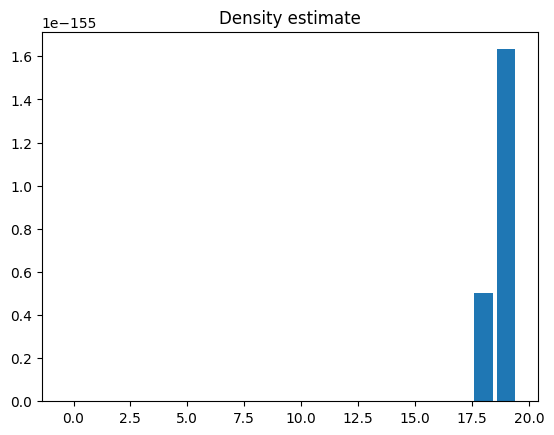

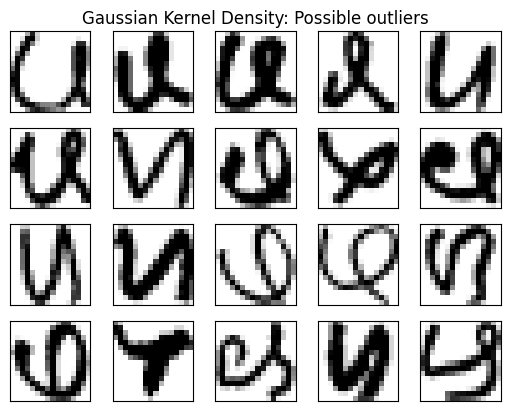

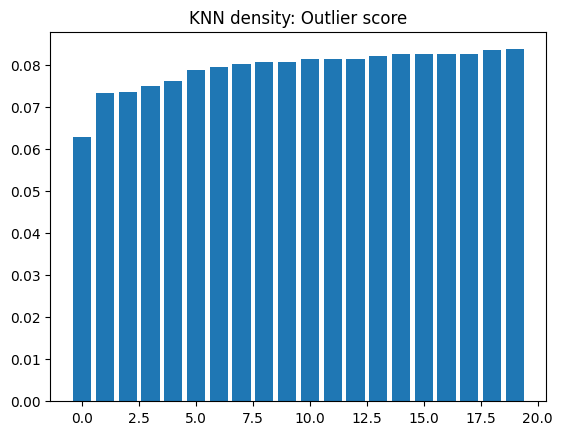

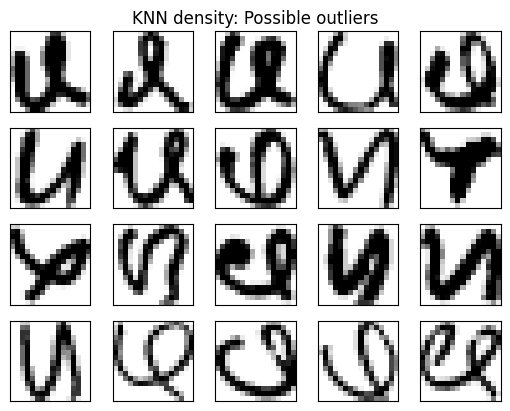

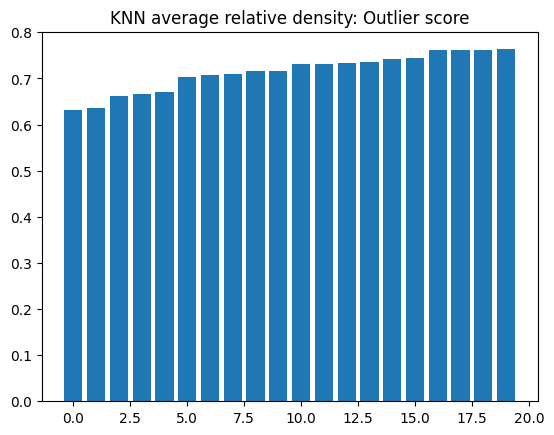

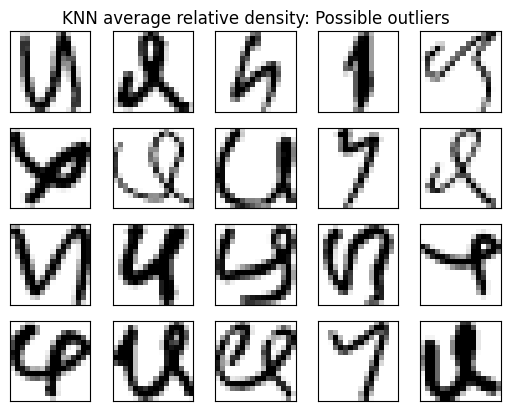

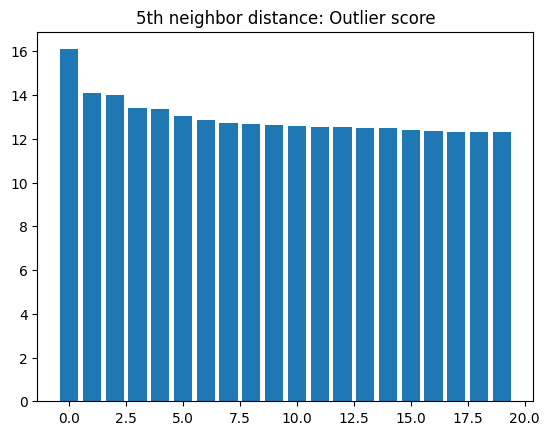

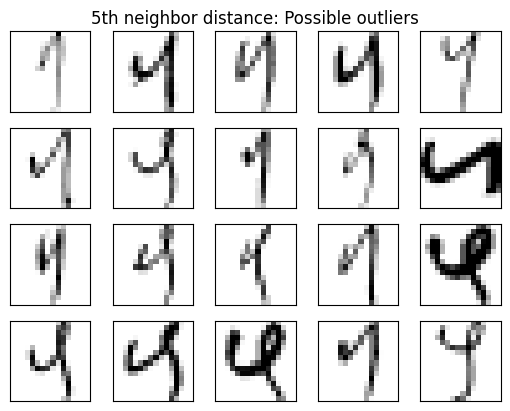

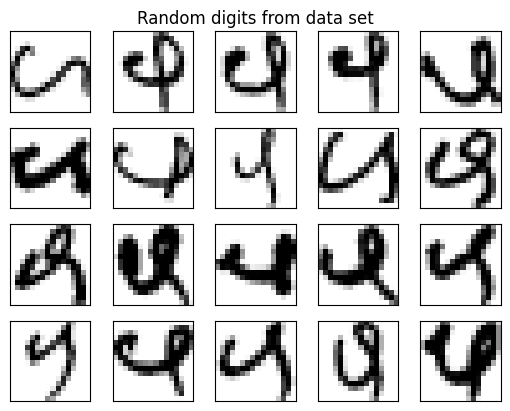

Ran Exercise 11.4.1


In [39]:
# exercise 11.4.1
import importlib_resources
import numpy as np
from matplotlib.pyplot import (
    bar,
    cm,
    figure,
    imshow,
    show,
    subplot,
    title,
    xticks,
    yticks,
)
from scipy.io import loadmat
from sklearn.neighbors import NearestNeighbors

from dtuimldmtools import gausKernelDensity

filename = importlib_resources.files("dtuimldmtools").joinpath("data/digits.mat")

# load data from Matlab data file
matdata = loadmat(filename)
X = np.array(matdata["X"])
y = np.array(matdata["y"])
N, M = np.shape(X)

# Restrict the data to images of "2"
X = X[y.ravel() == 2, :]
N, M = np.shape(X)

### Gausian Kernel density estimator
# cross-validate kernel width by leave-one-out-cross-validation
# (efficient implementation in gausKernelDensity function)
# evaluate for range of kernel widths
widths = X.var(axis=0).max() * (2.0 ** np.arange(-10, 3))
logP = np.zeros(np.size(widths))
for i, w in enumerate(widths):
    print("Fold {:2d}, w={:f}".format(i, w))
    density, log_density = gausKernelDensity(X, w)
    logP[i] = log_density.sum()

val = logP.max()
ind = logP.argmax()

width = widths[ind]
print("Optimal estimated width is: {0}".format(width))

# evaluate density for estimated width
density, log_density = gausKernelDensity(X, width)

# Sort the densities
i = (density.argsort(axis=0)).ravel()
density = density[i].reshape(
    -1,
)

# Plot density estimate of outlier score
figure(1)
bar(range(20), density[:20])
title("Density estimate")

# Plot possible outliers
figure(2)
for k in range(1, 21):
    subplot(4, 5, k)
    imshow(np.reshape(X[i[k], :], (16, 16)).T, cmap=cm.binary)
    xticks([])
    yticks([])
    if k == 3:
        title("Gaussian Kernel Density: Possible outliers")


### K-neighbors density estimator
# Neighbor to use:
K = 5
knn = NearestNeighbors(n_neighbors=K + 1).fit(X)


def density(X, i):
    """
    Compute density at observation i in X using LOO.
    Note this code can easily be vectorized for speed
    """
    D, _ = knn.kneighbors(np.expand_dims(X[i], axis=0))
    # don't compute distance to observation itself.
    density = 1.0 / D[:, 1:].mean(axis=1)
    return density


dens = np.concatenate([density(X, i) for i in range(N)])
# Sort the scores
i = dens.argsort()
dens = dens[i]

# Plot k-neighbor estimate of outlier score (distances)
figure(3)
bar(range(20), dens[:20])
title("KNN density: Outlier score")
# Plot possible outliers
figure(4)
for k in range(1, 21):
    subplot(4, 5, k)
    imshow(np.reshape(X[i[k], :], (16, 16)).T, cmap=cm.binary)
    xticks([])
    yticks([])
    if k == 3:
        title("KNN density: Possible outliers")


### K-nearest neigbor average relative density
# Compute the average relative density
def ard(X, i):
    _, J = knn.kneighbors(np.expand_dims(X[i], axis=0))
    J = J[0, 1:]  # don't include i itself.
    return density(X, i) / np.mean([density(X, j) for j in J])


avg_rel_density = np.concatenate([ard(X, i) for i in range(N)])

# Sort the avg.rel.densities
i_avg_rel = avg_rel_density.argsort()
avg_rel_density = avg_rel_density[i_avg_rel]

# Plot k-neighbor estimate of outlier score (distances)
figure(5)
bar(range(20), avg_rel_density[:20])
title("KNN average relative density: Outlier score")
# Plot possible outliers
figure(6)
for k in range(1, 21):
    subplot(4, 5, k)
    imshow(np.reshape(X[i_avg_rel[k], :], (16, 16)).T, cmap=cm.binary)
    xticks([])
    yticks([])
    if k == 3:
        title("KNN average relative density: Possible outliers")

### Distance to 5'th nearest neighbor outlier score
K = 5

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K + 1).fit(X)
D, i = knn.kneighbors(X)

# Outlier score
score = D[:, K - 1]
# Sort the scores
i = score.argsort()
score = score[i[::-1]]

# Plot k-neighbor estimate of outlier score (distances)
figure(7)
bar(range(20), score[:20])
title("5th neighbor distance: Outlier score")
# Plot possible outliers
figure(8)
for k in range(1, 21):
    subplot(4, 5, k)
    imshow(np.reshape(X[i[k], :], (16, 16)).T, cmap=cm.binary)
    xticks([])
    yticks([])
    if k == 3:
        title("5th neighbor distance: Possible outliers")


# Plot random digits (the first 20 in the data set), for comparison
figure(9)
for k in range(1, 21):
    subplot(4, 5, k)
    imshow(np.reshape(X[k, :], (16, 16)).T, cmap=cm.binary)
    xticks([])
    yticks([])
    if k == 3:
        title("Random digits from data set")
show()

print("Ran Exercise 11.4.1")
